In [ ]:
#screen
import FdsPy.qe.myqengine as qe
import pandas as pd

#define our universe expression
univ = qe.IdUniverse(['SP50'])

#define our time series
ts = qe.TimeSeries(start_date='-25Y',end_date = '0Y',frequency='D')
             
#define formulas
data_dict = {"price":"FG_PRICE(0)"}

calc = qe.Calculation(universe = univ, dates =ts,data_dict=data_dict)
calc.query()
df = calc.data.copy()

df

In [1]:
import pandas as pd
#df.to_pickle('sp50_price_daily_25y.pkl')
df = pd.read_pickle('sp50_price_daily_25y.pkl')

In [2]:
import numpy as np
df['date'] = pd.to_datetime(df['DATE'])

df=df.drop(columns = ['DATE'])
#df =df.set_index("date")
df=df.dropna()
df = df.rename(columns = {"date":'ds',
                          "UNIVERSE":"unique_id",
                          "price":'y'})

#df['lprice']= df['y'].shift()
df['ma_10'] =df['y'].rolling(10).mean()
df['ma_30'] =df['y'].rolling(30).mean()
df['ma_50'] =df['y'].rolling(50).mean()
df['ma_120'] =df['y'].rolling(120).mean()
df['ma_250'] =df['y'].rolling(250).mean()

df['10_30'] = df['ma_10']- df['ma_30']
df['30_50'] = df['ma_30']- df['ma_50']
df['10_50'] = df['ma_10']- df['ma_50']
df['10_120'] = df['ma_10']- df['ma_120']
df['50_120'] = df['ma_50']- df['ma_120']
df['30_50'] = df['ma_30']- df['ma_50']
df['30_120'] = df['ma_30']- df['ma_120']
df['10_250'] = df['ma_10']- df['ma_250']
df['50_1250'] = df['ma_50']- df['ma_250']
df['120_250'] = df['ma_30']- df['ma_250']
df['30_250'] = df['ma_30']- df['ma_250']

df['vol_10'] =df['y'].rolling(10).std()
df['vol_30'] =df['y'].rolling(30).std()
df['vol_50'] =df['y'].rolling(50).std()
df['vol_120'] =df['y'].rolling(120).std()

df

,unique_id,y,ds,ma_10,ma_30,ma_50,ma_120,ma_250,10_30,30_50,...,50_120,30_120,10_250,50_1250,120_250,30_250,vol_10,vol_30,vol_50,vol_120
0,SP50,970.43,1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SP50,975.04,1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SP50,977.07,1998-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SP50,939.21,1998-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SP50,952.12,1998-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6287,SP50,3829.25,2022-12-27,3886.682,3955.478667,3885.4504,3921.651500,4110.99340,-68.796667,70.028267,...,-36.201100,33.827167,-224.31140,-225.54300,-155.514733,-155.514733,74.173189,74.246015,117.755681,172.352182
6288,SP50,3839.50,2022-12-30,3877.194,3950.364333,3888.6814,3921.125500,4107.23648,-73.170333,61.682933,...,-32.444100,29.238833,-230.04248,-218.55508,-156.872147,-156.872147,73.458816,76.817161,114.105812,172.507000
6289,SP50,3849.28,2022-12-29,3860.157,3946.765333,3891.2674,3920.708000,4103.46136,-86.608333,55.497933,...,-29.440600,26.057333,-243.30436,-212.19396,-156.696027,-156.696027,53.901829,78.982201,111.643073,172.620659
6290,SP50,3844.82,2022-12-23,3845.107,3941.868333,3894.2606,3920.627917,4099.77592,-96.761333,47.607733,...,-26.367317,21.240417,-254.66892,-205.51532,-157.907587,-157.907587,25.494720,80.635208,108.232168,172.653891


In [3]:
df.drop(columns = ['unique_id'],inplace=True)

df.set_index('ds',inplace=True)
df

,y,ma_10,ma_30,ma_50,ma_120,ma_250,10_30,30_50,10_50,10_120,50_120,30_120,10_250,50_1250,120_250,30_250,vol_10,vol_30,vol_50,vol_120
ds,,,,,,,,,,,,,,,,,,,,
1997-12-31,970.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-02,975.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-05,977.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-12,939.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-13,952.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3829.25,3886.682,3955.478667,3885.4504,3921.651500,4110.99340,-68.796667,70.028267,1.2316,-34.969500,-36.201100,33.827167,-224.31140,-225.54300,-155.514733,-155.514733,74.173189,74.246015,117.755681,172.352182
2022-12-30,3839.50,3877.194,3950.364333,3888.6814,3921.125500,4107.23648,-73.170333,61.682933,-11.4874,-43.931500,-32.444100,29.238833,-230.04248,-218.55508,-156.872147,-156.872147,73.458816,76.817161,114.105812,172.507000
2022-12-29,3849.28,3860.157,3946.765333,3891.2674,3920.708000,4103.46136,-86.608333,55.497933,-31.1104,-60.551000,-29.440600,26.057333,-243.30436,-212.19396,-156.696027,-156.696027,53.901829,78.982201,111.643073,172.620659


In [4]:
df=df.dropna()

In [21]:
X_train= df[df.index < pd.Timestamp(2021,12,31)].drop(columns = ['y']) 
y_train= df[df.index < pd.Timestamp(2021,12,31)]['y'] 
X_test= df[df.index >= pd.Timestamp(2021,12,31)].drop(columns = ['y']) 
y_test= df[df.index >= pd.Timestamp(2021,12,31)]['y'] 
X_test

,ma_10,ma_30,ma_50,ma_120,ma_250,10_30,30_50,10_50,10_120,50_120,30_120,10_250,50_1250,120_250,30_250,vol_10,vol_30,vol_50,vol_120
ds,,,,,,,,,,,,,,,,,,,
2021-12-31,4717.575,4671.316333,4656.3880,4522.531083,4277.88384,46.258667,14.928333,61.1870,195.043917,133.856917,148.785250,439.69116,378.50416,393.432493,393.432493,80.892784,75.238347,70.868439,132.145026
2022-01-03,4735.167,4674.603000,4661.4212,4526.049917,4282.07752,60.564000,13.181800,73.7458,209.117083,135.371283,148.553083,453.08948,379.34368,392.525480,392.525480,76.478198,78.524207,71.720320,133.776691
2022-01-04,4757.719,4677.569667,4666.8994,4529.662500,4286.03652,80.149333,10.670267,90.8196,228.056500,137.236900,147.907167,471.68248,380.86288,391.533147,391.533147,50.578425,81.325492,71.127438,135.102526
2022-01-05,4758.121,4678.157667,4669.5814,4532.774333,4289.54012,79.963333,8.576267,88.5396,225.346667,136.807067,145.383333,468.58088,380.04128,388.617547,388.617547,50.051551,81.429364,69.779124,134.698977
2022-01-06,4762.803,4677.977333,4672.0066,4536.420667,4293.08496,84.825667,5.970733,90.7964,226.382333,135.585933,141.556667,469.71804,378.92164,384.892373,384.892373,39.892589,81.381956,68.513111,133.124869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3886.682,3955.478667,3885.4504,3921.651500,4110.99340,-68.796667,70.028267,1.2316,-34.969500,-36.201100,33.827167,-224.31140,-225.54300,-155.514733,-155.514733,74.173189,74.246015,117.755681,172.352182
2022-12-30,3877.194,3950.364333,3888.6814,3921.125500,4107.23648,-73.170333,61.682933,-11.4874,-43.931500,-32.444100,29.238833,-230.04248,-218.55508,-156.872147,-156.872147,73.458816,76.817161,114.105812,172.507000
2022-12-29,3860.157,3946.765333,3891.2674,3920.708000,4103.46136,-86.608333,55.497933,-31.1104,-60.551000,-29.440600,26.057333,-243.30436,-212.19396,-156.696027,-156.696027,53.901829,78.982201,111.643073,172.620659


In [22]:
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
import xgboost as xgb

reg = xgb.XGBRegressor(
    n_estimators=1000,
    random_state=42
)

# It's Confromal Prediction time!
alpha = 0.005
gap = 3

mapie_cv = BlockBootstrap(
    n_blocks=1000,
    overlapping=True,
    random_state=42
)

mapie_enbpi = MapieTimeSeriesRegressor(
    reg,
    method="enbpi",
    cv=mapie_cv,
    agg_function="mean",
    n_jobs=-1
)


In [23]:
reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)

mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

In [25]:
import numpy as np
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

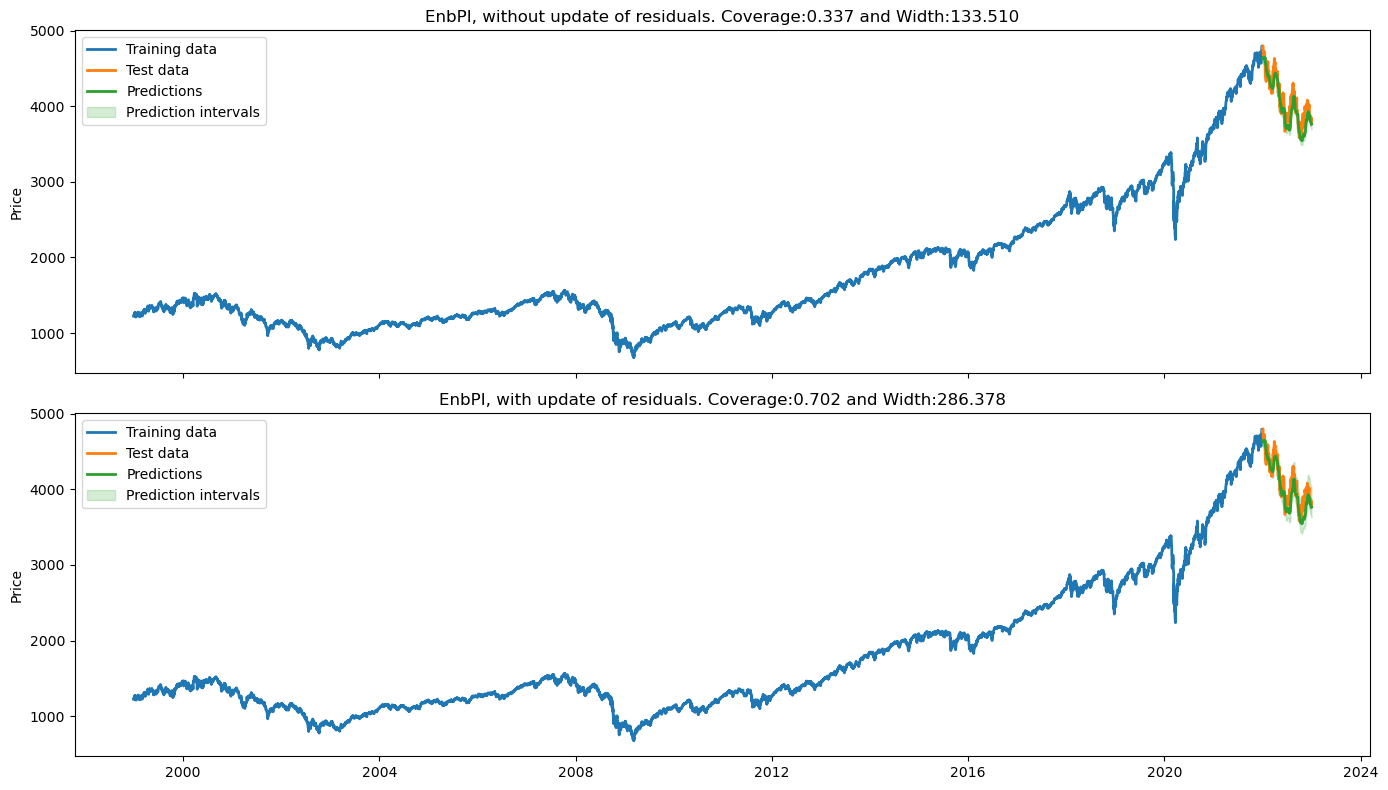

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Price")
    ax.plot(
        y_train,#[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
plt.show()

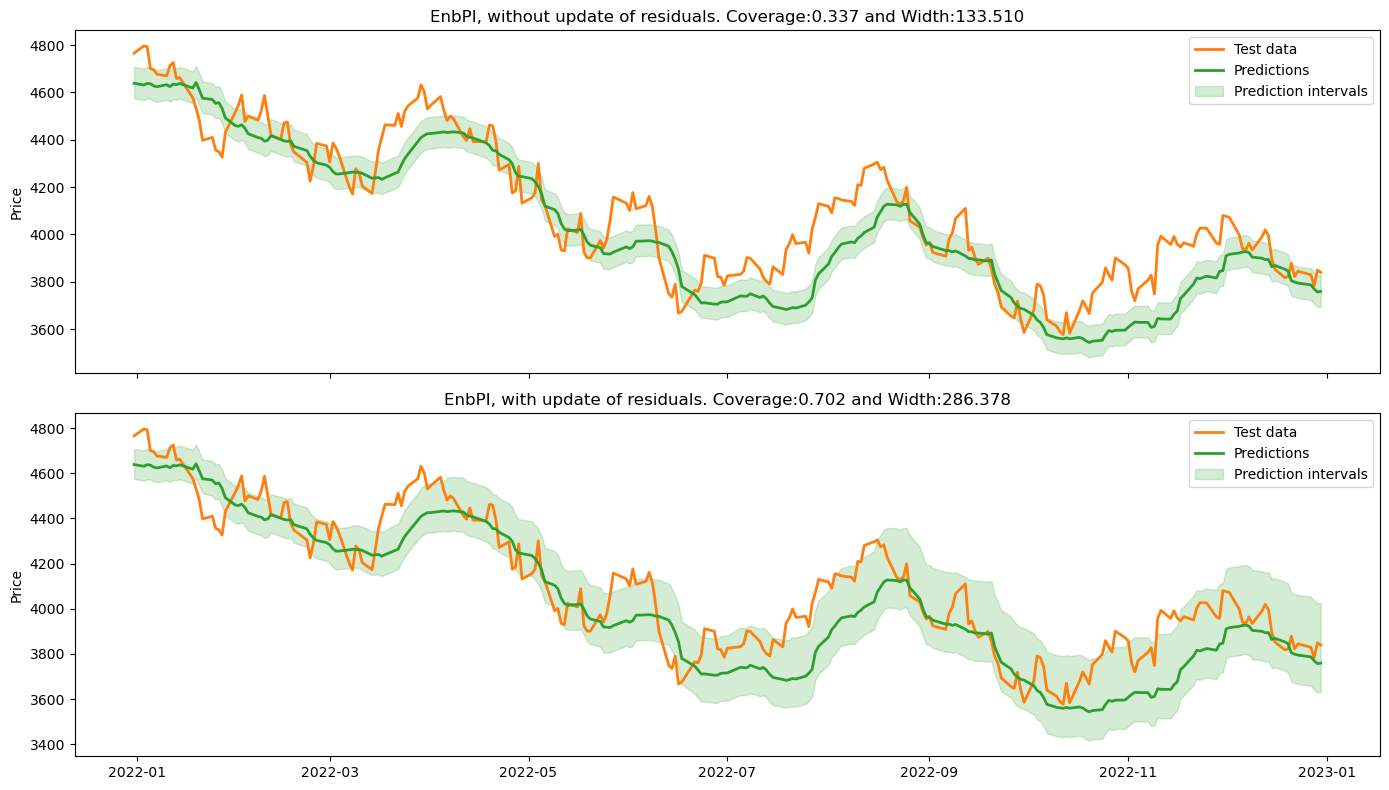

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]
y_test = y_test.sort_index()

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Price")
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
plt.show()